In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import re
import plotly as pl 
import matplotlib.pyplot as plt



In [2]:
df_chocolate = pd.read_csv("clean_flavors_of_cacao.csv", encoding='utf-8')
df_chocolate.head()

,Company,Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin_Country,Ingredients,Most_Memorable_Characteristics,continent
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,missing,Sao Tome & Principe,"4- B,S,C,L","sweet, chocolatey, vegetal",Africa
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,missing,Togo,"4- B,S,C,L","burnt wood, earthy, choco",Africa
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,missing,Togo,"4- B,S,C,L","roasty, acidic, nutty",Africa
3,A. Morin,Akata,1680,2015,70.0,France,3.50,missing,Togo,"4- B,S,C,L","mild profile, chocolaty, spice",Africa
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,missing,Peru,"4- B,S,C,L","grainy texture, cocoa, sweet",South America


# Machine Learning 



In [3]:
def bin_ratings(rating):
    if rating == 5.75: return 3
    if rating == 5.50: return 3
    if rating == 5.25: return 3
    if rating == 5.00: return 3
    
    if rating == 4.75: return 3
    if rating == 4.50: return 3
    if rating == 4.25: return 3
    if rating == 4.00: return 3
    
    if rating == 3.75: return 3
    if rating == 3.50: return 2
    if rating == 3.25: return 2
    if rating == 3.00: return 2

    if rating == 2.75: return 1
    if rating == 2.50: return 1
    if rating == 2.25: return 1
    if rating == 2.00: return 1
    
    if rating == 1.75: return 1
    if rating == 1.50: return 1
    if rating == 1.25: return 1
    if rating == 1.00: return 1
    
    #print( f"error: rating={rating} type={type(rating)}" )
    return "6"

In [4]:
df_chocolate['Rating'] = df_chocolate['Rating'].apply(bin_ratings)


In [5]:
def to_string(value):
    other = f"_{value}_"
    return other

In [6]:
def reduce_count_vals(df, colname, threshold):
    counts = df[colname].value_counts()
    replace_list = list(counts[counts < threshold].index)

    # Replace in dataframe
    for item in replace_list:
       df[colname] = df[colname].replace(item,"Other")

In [7]:
df_chocolate['Review_Date']= df_chocolate['Review_Date'].apply(to_string)
reduce_count_vals(df_chocolate, 'Review_Date', 100)

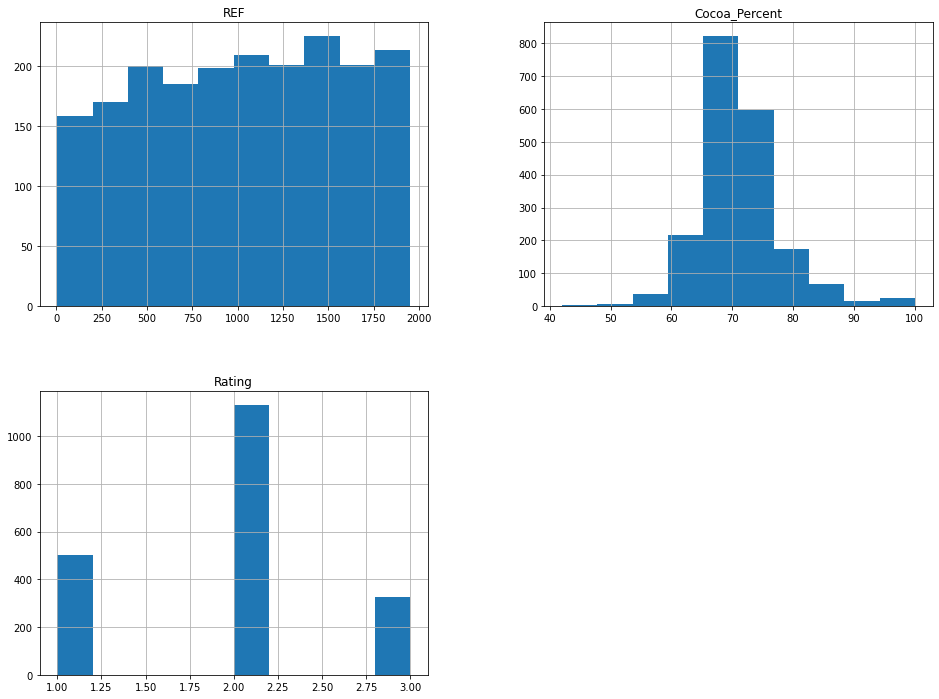

In [8]:
df_chocolate.hist(figsize=(16, 12));

## Neural Network!

In [9]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
df_chocolate= df_chocolate.drop(columns=["REF","Bean_Origin_or_Bar_Name","Most_Memorable_Characteristics","continent"], axis=1)
df_chocolate.head()

,Company,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin_Country,Ingredients
0,A. Morin,_2016_,63.0,France,3,missing,Sao Tome & Principe,"4- B,S,C,L"
1,A. Morin,_2015_,70.0,France,1,missing,Togo,"4- B,S,C,L"
2,A. Morin,_2015_,70.0,France,2,missing,Togo,"4- B,S,C,L"
3,A. Morin,_2015_,70.0,France,2,missing,Togo,"4- B,S,C,L"
4,A. Morin,_2015_,70.0,France,2,missing,Peru,"4- B,S,C,L"


In [10]:
# Generate our categorical variable lists
chocolate_cat = df_chocolate.dtypes[df_chocolate.dtypes == 'object'].index.tolist()
chocolate_cat

['Company',
 'Review_Date',
 'Company_Location',
 'Bean_Type',
 'Broad_Bean_Origin_Country',
 'Ingredients']

In [11]:


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_chocolate[chocolate_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(chocolate_cat)
encode_df.head()



,Company_A. Morin,Company_AMMA,Company_Acalli,Company_Adi,Company_Aequare (Gianduja),Company_Ah Cacao,Company_Akesson's (Pralus),Company_Alain Ducasse,Company_Alexandre,Company_Altus aka Cao Artisan,...,"Ingredients_4- B,S,V,L","Ingredients_4- B,Sw,C,L","Ingredients_4- B,Sw,C,Sa","Ingredients_4- B,Sw,C,V","Ingredients_4- B,Sw,V,L","Ingredients_5- B,S,C,L,Sa","Ingredients_5- B,S,C,V,L","Ingredients_5-B,S,C,V,Sa","Ingredients_6-B,S,C,V,L,Sa",Ingredients_Unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Merge one-hot encoded features and drop the originals
df_chocolate = df_chocolate.merge(encode_df, left_index=True, right_index=True).drop(chocolate_cat, 1)
df_chocolate.head()

,Cocoa_Percent,Rating,Company_A. Morin,Company_AMMA,Company_Acalli,Company_Adi,Company_Aequare (Gianduja),Company_Ah Cacao,Company_Akesson's (Pralus),Company_Alain Ducasse,...,"Ingredients_4- B,S,V,L","Ingredients_4- B,Sw,C,L","Ingredients_4- B,Sw,C,Sa","Ingredients_4- B,Sw,C,V","Ingredients_4- B,Sw,V,L","Ingredients_5- B,S,C,L,Sa","Ingredients_5- B,S,C,V,L","Ingredients_5-B,S,C,V,Sa","Ingredients_6-B,S,C,V,L,Sa",Ingredients_Unknown
0,63.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,70.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,70.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,70.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Split our preprocessed data into our features and target arrays
y = df_chocolate["Rating"]
X = df_chocolate.drop(["Rating"],1) 

# Split the preprocessed data into a training and testing dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

X_train, X_test, y_train, y_test = train_test_split(X,
   y,test_size= 0.4,train_size=0.6 , random_state=42, stratify=y)

In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)


In [16]:
etc = ExtraTreesClassifier()
_ = etc.fit(X_resampled, y_resampled)
y_pred = etc.predict(X_test_scaled)

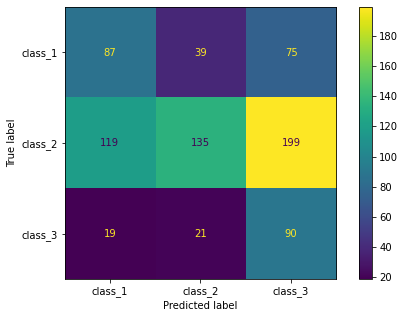

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["class_1", "class_2", "class_3"],
)
cmp.plot(ax=ax)
plt.show();

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.39      0.43      0.41       201
           2       0.69      0.30      0.42       453
           3       0.25      0.69      0.36       130

    accuracy                           0.40       784
   macro avg       0.44      0.47      0.40       784
weighted avg       0.54      0.40      0.41       784



In [19]:
len(X_train_scaled[0])

571

# Random Forest

In [20]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")



 Random forest predictive accuracy: 0.411


In [21]:
# Calculated the balanced accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.4107142857142857

In [22]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2", "Actual 3"], columns=["Predicted 1", "Predicted 2","Predicted 3"])
cm_df

,Predicted 1,Predicted 2,Predicted 3
Actual 1,95,40,66
Actual 2,110,144,199
Actual 3,21,26,83


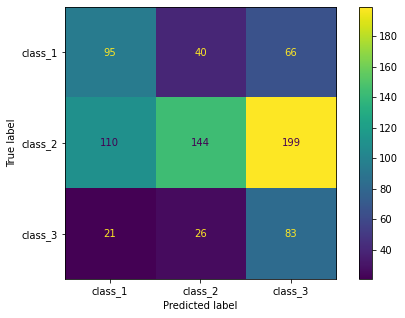

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["class_1", "class_2", "class_3"],
)
cmp.plot(ax=ax)
plt.show();

In [25]:
# Print the imbalanced classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.42      0.47      0.44       201
           2       0.69      0.32      0.43       453
           3       0.24      0.64      0.35       130

    accuracy                           0.41       784
   macro avg       0.45      0.48      0.41       784
weighted avg       0.54      0.41      0.42       784



In [ ]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_



In [ ]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

# Support Vector Machine

In [ ]:
# Create the SVM model
svm = SVC(kernel='rbf')

# Train the model
svm.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = svm.predict(X_test_scaled)
print(f" SVM model accuracy: {accuracy_score(y_test,y_pred):.3f}")

In [ ]:
# Calculated the balanced accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2","Actual 3"], columns=["Predicted 1", "Predicted 2","Predicted 3"])
cm_df

In [ ]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Deep Learning Model

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  256
hidden_nodes_layer2 = 128
hidden_nodes_layer3 = 64
hidden_nodes_layer4 = 32
hidden_nodes_layer5 = 16
hidden_nodes_layer6 = 8
hidden_nodes_layer7 = 4


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, input_dim = number_input_features, activation = 'relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = 'relu'))

# other hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer3, activation = 'relu'))
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer4, activation = 'relu'))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer5, activation = 'relu'))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer6, activation = 'relu'))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer7, activation = 'relu'))


# Output layer
nn.add(tf.keras.layers.Dense(units = 3, activation = 'softmax'))

# Check the structure of the model
nn.summary()

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [ ]:
# Compile the model
nn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

In [ ]:
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

In [ ]:
# Train the model
nn.fit(X_train_scaled, y_train, epochs = 100, callbacks=[cp_callback])

In [ ]:


# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")



In [ ]:
nn.save("Chocolate_Ratings_ML_Multiclass.h5")